# Introduction 

Identifying the risk of obesity in a patient using a `RandomForestClassifier` model as it provides quick and precise solutions to such data.

## Importing modules

In [2]:
# required modules
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import LabelEncoder

# modules to model data
from lazypredict.Supervised import LazyClassifier
from sklearn import preprocessing
from sklearn.model_selection import train_test_split


# Modules to check accuracy
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import sklearn.metrics as metrics
import itertools

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Importing data

Import both `test.csv` and `train.csv` seperately.

In [3]:
df_test = pd.read_csv("obesity_test.csv")
df_train = pd.read_csv("obesity_train.csv")

print(f"The shapes of the two dataframes are: \n test: {df_test.shape}, train: {df_train.shape}")
df_train.head()

The shapes of the two dataframes are: 
 test: (13840, 17), train: (20758, 18)


,id,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,0,Male,24.44,1.70,81.67,yes,yes,2.00,2.98,Sometimes,no,2.76,no,0.00,0.98,Sometimes,Public_Transportation,Overweight_Level_II
1,1,Female,18.00,1.56,57.00,yes,yes,2.00,3.00,Frequently,no,2.00,no,1.00,1.00,no,Automobile,Normal_Weight
2,2,Female,18.00,1.71,50.17,yes,yes,1.88,1.41,Sometimes,no,1.91,no,0.87,1.67,no,Public_Transportation,Insufficient_Weight
3,3,Female,20.95,1.71,131.27,yes,yes,3.00,3.00,Sometimes,no,1.67,no,1.47,0.78,Sometimes,Public_Transportation,Obesity_Type_III
4,4,Male,31.64,1.91,93.80,yes,yes,2.68,1.97,Sometimes,no,1.98,no,1.97,0.93,Sometimes,Public_Transportation,Overweight_Level_II


**What do we need to predict?**

The answer is the missing column from the test data.

*Note: This method can be used if the data does not come with a detailed catalogue with it.*

In [4]:
print("The prediction column is ", set(df_train.columns) ^ (set(df_test.columns)))

The prediction column is  {'NObeyesdad'}


## Inspecting data

In [5]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20758 entries, 0 to 20757
Data columns (total 18 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              20758 non-null  int64  
 1   Gender                          20758 non-null  object 
 2   Age                             20758 non-null  float64
 3   Height                          20758 non-null  float64
 4   Weight                          20758 non-null  float64
 5   family_history_with_overweight  20758 non-null  object 
 6   FAVC                            20758 non-null  object 
 7   FCVC                            20758 non-null  float64
 8   NCP                             20758 non-null  float64
 9   CAEC                            20758 non-null  object 
 10  SMOKE                           20758 non-null  object 
 11  CH2O                            20758 non-null  float64
 12  SCC                             

The data is clean as there are no null values in any of the columns so we can proceed with analyzing the data  right away.

# EDA

#### Handling Catagorical data

We must inspect catgorical data and transform them to suitable numerical values where we can use them to frame the model.

To do that we first need to know tha number of catagories for each catagorical column.

In [6]:
print('The number of unique elements in each ofthe objective/catagorical columns are as follows:')

uniq = df_train.select_dtypes("object").apply(lambda x: x.unique()).apply(lambda x: len(x))
## the first `apply` is to select a column the second `apply` is to select the length of the uniuque list
# create a dataframe
uniq = uniq.to_frame().sort_values(by=0)
uniq.columns = ['unique_values']
uniq

The number of unique elements in each ofthe objective/catagorical columns are as follows:


,unique_values
Gender,2
family_history_with_overweight,2
FAVC,2
SMOKE,2
SCC,2
CALC,3
CAEC,4
MTRANS,5
NObeyesdad,7


In [7]:
# output the list of unique readings
df_train[uniq.index].apply( lambda x: list(x.unique()) 
                           ).to_frame("Feature_Unique_Values")

,Feature_Unique_Values
Gender,"[Male, Female]"
family_history_with_overweight,"[yes, no]"
FAVC,"[yes, no]"
SMOKE,"[no, yes]"
SCC,"[no, yes]"
CALC,"[Sometimes, no, Frequently]"
CAEC,"[Sometimes, Frequently, no, Always]"
MTRANS,"[Public_Transportation, Automobile, Walking, M..."
NObeyesdad,"[Overweight_Level_II, Normal_Weight, Insuffici..."


Since we would not want to create a change in our dataset that would override the original data it is advised to make a copy and apply these changes to it.

In [8]:
# create a copy of df_train
df = df_train.copy()     
cat_cols = df.select_dtypes("object").columns.tolist()
# remove tareget column from cat_cols
cat_cols.remove('NObeyesdad')
# create multiple label encoders one for each categorical column
# stotre the encoders in a dictionary
label_encoders = {}
for col in cat_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le
df.head()

# create a dataframe view for encoding


#print label of each encoder
encoding = pd.DataFrame({"Columns" : label_encoders.keys(),
                        "Classes": [label_encoders[column].classes_ for column in label_encoders.keys()]})
encoding = encoding.explode('Classes')
# create code column
encoding["Encoding"] = [label_encoders[column].transform([k])[0] 
                   for column, k in zip(encoding['Columns'], encoding['Classes'])]

In [9]:
# count specific values inside the columns of interest from df_train
encoding["Count"] = [int(df_train[column].value_counts().to_dict()[k]) for column, k in zip(encoding['Columns'], encoding['Classes'])]
encoding.head()

,Columns,Classes,Encoding,Count
0,Gender,Female,0,10422
0,Gender,Male,1,10336
1,family_history_with_overweight,no,0,3744
1,family_history_with_overweight,yes,1,17014
2,FAVC,no,0,1776


In [10]:
encoding["Columns"].replace({"family_history_with_overweight":"Family_history"}, inplace=True)

In [11]:
# verify counts
for col in cat_cols:
    print(df_train[col].value_counts().to_dict())

{'Female': 10422, 'Male': 10336}
{'yes': 17014, 'no': 3744}
{'yes': 18982, 'no': 1776}
{'Sometimes': 17529, 'Frequently': 2472, 'Always': 478, 'no': 279}
{'no': 20513, 'yes': 245}
{'no': 20071, 'yes': 687}
{'Sometimes': 15066, 'no': 5163, 'Frequently': 529}
{'Public_Transportation': 16687, 'Automobile': 3534, 'Walking': 467, 'Motorbike': 38, 'Bike': 32}


In [12]:
encoding = encoding.set_index(["Columns", "Classes"])
encoding.head()

Encoding  Count
Columns        Classes                 
Gender         Female          0  10422
               Male            1  10336
Family_history no              0   3744
               yes             1  17014
FAVC           no              0   1776

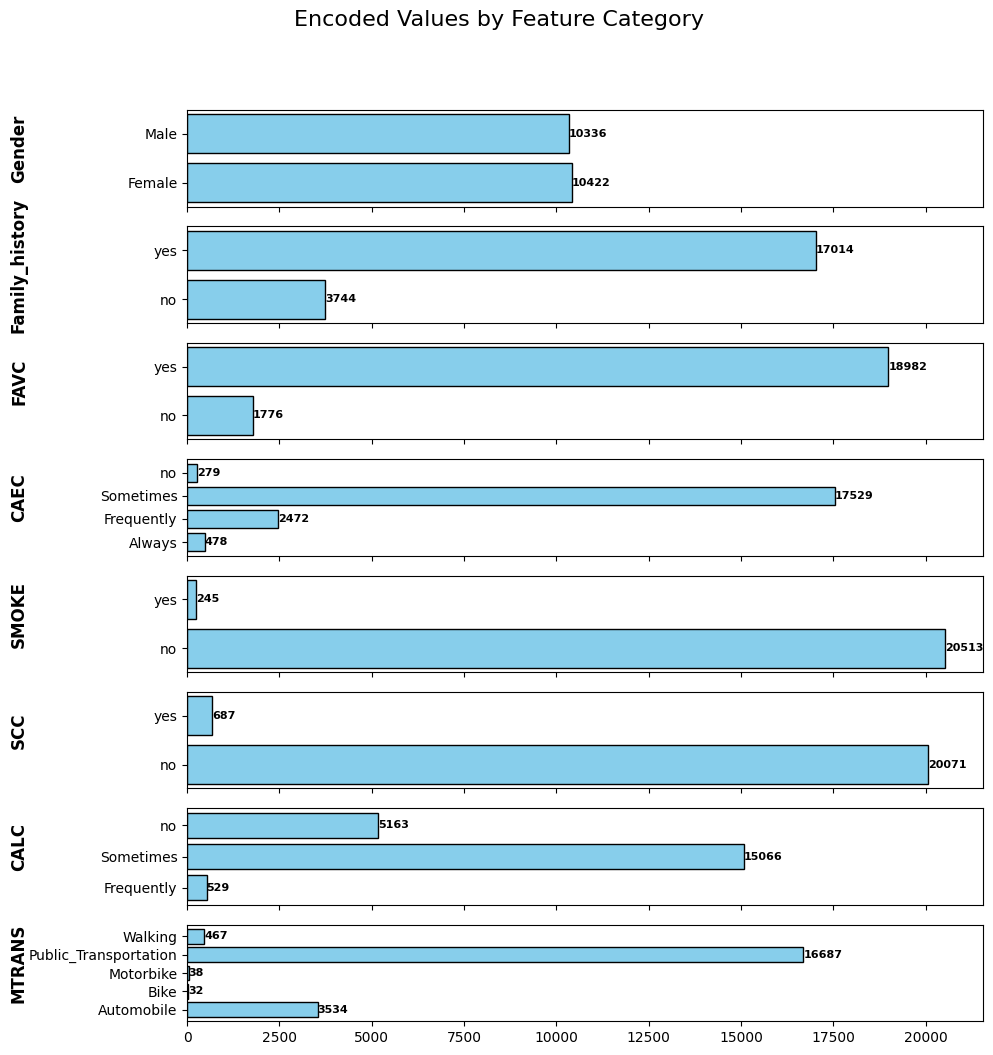

In [13]:
# Get unique 'Columns' values to determine how many subgraphs we need
cat_cols = encoding.index.get_level_values('Columns').unique()
n_cat_cols = len(cat_cols)

# Create a figure with 1 row and 'n_cat_cols' columns
# sharey=True is critical: it forces all subgraphs to use the same Y-axis scale
fig, axes = plt.subplots(n_cat_cols, 1,
                         figsize=(10, 10), sharex=True)


for i, col_name in enumerate(cat_cols):
    # Select the data for this specific column group
    subset = encoding.xs(col_name, level='Columns')
    
    # Plot bars on the specific subplot (axes[i])
    bars = axes[i].barh(subset.index, subset['Count'], 
                        color='skyblue', edgecolor='black')
    axes[i].set_ylabel(col_name, 
                       fontsize=12, fontweight='bold', 
                       labelpad = 20, 
                       rotation = 90, 
                       ha = 'center')
    axes[i].get_yaxis().set_label_coords(-0.2, 0.6)
    
    # Customizing each subgraph
    axes[i].tick_params(axis='x')
    
    # Add 'Count' as text labels on top of bars for extra detail
    for bar, count in zip(bars, subset['Count']):
        width = bar.get_width()
        axes[i].text(width + 0.01, bar.get_y() + bar.get_height()/2,
                     f'{count}', va='center', fontsize=8, fontweight='bold')

# Final global styling
plt.suptitle("Encoded Values by Feature Category", fontsize=16, y=1.05)

plt.tight_layout()
plt.show()

Doing `NObeyesdad` seperately will allow us to inverse transform the predictions at the end.

In [14]:
nobeyesdad = LabelEncoder()
df.NObeyesdad = nobeyesdad.fit_transform(df.NObeyesdad)
df.head()

,id,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,0,1,24.44,1.70,81.67,1,1,2.00,2.98,2,0,2.76,0,0.00,0.98,1,3,6
1,1,0,18.00,1.56,57.00,1,1,2.00,3.00,1,0,2.00,0,1.00,1.00,2,0,1
2,2,0,18.00,1.71,50.17,1,1,1.88,1.41,2,0,1.91,0,0.87,1.67,2,3,0
3,3,0,20.95,1.71,131.27,1,1,3.00,3.00,2,0,1.67,0,1.47,0.78,1,3,4
4,4,1,31.64,1.91,93.80,1,1,2.68,1.97,2,0,1.98,0,1.97,0.93,1,3,6


All of the Object type columns are now transformed into numerical catagories.

<details> <summary> OR manually transforming the data </summary>

    gender = {'Male':1, 'Female':2}
    df.Gender = df.Gender.map(gender)

    calc = { 'no':0, 'Sometimes':1, 'Frequently':2}
    df.CALC = df.CALC.map(calc)

    caec = {'no':0, 'Sometimes':1, 'Frequently':2, 'Always':3}
    df.CAEC = df.CAEC.map(caec)

    mtrans = {'Public_Transportation':1, 'Automobile':2, 'Walking':3, 'Motorbike':4, 'Bike':5}
    df.MTRANS = df.MTRANS.map(mtrans)

    nobeyesdad = {'Insufficient_Weight':0, 'Normal_Weight':1, 'Obesity_Type_I':2, 'Obesity_Type_II':3, 'Obesity_Type_III':4, 'Overweight_Level_I':5, 'Overweight_Level_II':6}
    df.NObeyesdad = df.NObeyesdad.map(nobeyesdad)

</details>


Now as all the columns are in numerical format we must now check for the columns to use for predicting our model. To do that we will use the _Spearman's correlation_ matrix.

# Selecting data

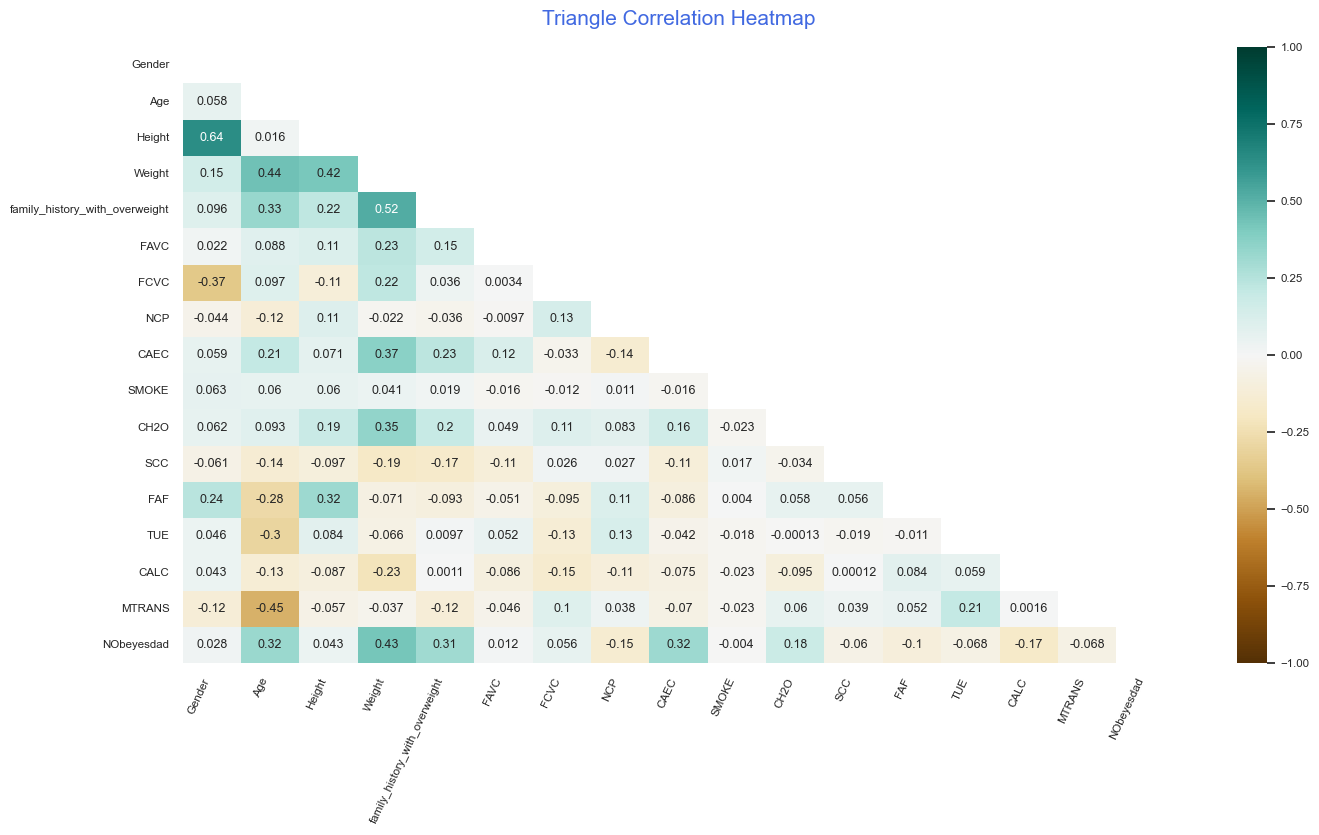

In [15]:
# Set the theme for the plot in seaborn
plt.figure(figsize=(16,8))
sns.set_theme(context='notebook', style='whitegrid',
              palette='deep', font='sans-serif',
              font_scale=0.75, color_codes=True, rc=None
             )
# Using the Spearman correlation
df_corr = df.drop('id', axis=1).corr(method = "spearman")
# create a mask for the upper triangle of the correlation matrix
mask = np.triu(np.ones_like(df_corr, 
                            dtype = bool)
              )
# create a heatmap to visualize the correlation matrix
heatmap = sns.heatmap(df_corr, 
                      mask = mask,                 # mask the upper triangle
                      vmin = -1 , vmax = 1,        # caliberate the colorbar
                      annot = True , cmap="BrBG"
                     )
heatmap.set_title("Triangle Correlation Heatmap" , 
                  fontdict = {'fontsize': 15, 'color':'royalblue'}, pad=16 
                 )
plt.grid(False)
plt.xticks(rotation=65, ha='right')
plt.show()

Select the columns that are closely correlated.

In [16]:
# set a minimum coreelation coefficient value
min_corr = 0.3
# select the columns with sufficiently high positive or negative correlation
rel_cols = df_corr.apply( lambda x: x.apply( lambda cell_val: cell_val if ((cell_val >= min_corr) | (cell_val < - min_corr)) & (cell_val !=1) else np.nan) 
             ).dropna(axis=1, how='all'                   # drop columns with all null values
                     ).dropna(axis=0, how='all').columns          # drop rows with all null values
X = df[rel_cols].drop(columns=["NObeyesdad"], axis=1)
X.head()

,Gender,Age,Height,Weight,family_history_with_overweight,FCVC,CAEC,CH2O,FAF,TUE,MTRANS
0,1,24.44,1.70,81.67,1,2.00,2,2.76,0.00,0.98,3
1,0,18.00,1.56,57.00,1,2.00,1,2.00,1.00,1.00,0
2,0,18.00,1.71,50.17,1,1.88,2,1.91,0.87,1.67,3
3,0,20.95,1.71,131.27,1,3.00,2,1.67,1.47,0.78,3
4,1,31.64,1.91,93.80,1,2.68,2,1.98,1.97,0.93,3


In [17]:
y = df.NObeyesdad
X.shape, df.shape, y.shape

((20758, 11), (20758, 18), (20758,))

The number of rows remains the same only the less rlelvant columns have been filtered out.

# Selecting an appropriate model

Lazypredict runs the model to find the accuracy andother related information for different classifier models and will tell us the most suitable model to use. 
<details>
    <summary> This is the code for the same </summary>
        # clf = LazyClassifier(verbose=0,
        #             ignore_warnings=True, 
        #             custom_metric=None,
        #            )
        # models, predictions = clf.fit(X_train, X_test, y_train, y_test)
        # # print top 5 models
        # models[0:5]
</details>

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=.3,random_state =13) # test size is 30%

In [19]:
# models, predictions = LazyClassifier(X_train, y_train, X_test, y_test)

I have previously run the lazy predict so I do not need to run it again and again. The result of which you can see in the `models` datafrme.

In [20]:
# previously run
models = pd.read_csv("model_comparison.csv")
print("Top 10 models are: ")
models.head(10)

Top 10 models are: 


,Model,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
0,XGBClassifier,0.89,0.88,NaN,0.89,2.79
1,LGBMClassifier,0.89,0.88,NaN,0.89,10.40
2,RandomForestClassifier,0.88,0.87,NaN,0.88,3.76
3,BaggingClassifier,0.87,0.86,NaN,0.87,1.36
4,ExtraTreesClassifier,0.87,0.85,NaN,0.87,2.02
5,SVC,0.86,0.84,NaN,0.85,9.65
6,LogisticRegression,0.85,0.84,NaN,0.85,0.77
7,DecisionTreeClassifier,0.83,0.82,NaN,0.83,0.12
8,LinearDiscriminantAnalysis,0.81,0.79,NaN,0.81,0.63
9,NuSVC,0.81,0.79,NaN,0.81,30.74


# Creating a model

In [21]:
# import XGBclassifier
from xgboost import XGBClassifier

In [22]:
# creaete the XGBClassifier model
xgbc = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss',
                        n_estimators=200,
                          )
xgbc.fit(X_train, y_train)

,"objective objective: typing.Union[str, xgboost.sklearn._SklObjWProto, typing.Callable[[typing.Any, typing.Any], typing.Tuple[numpy.ndarray, numpy.ndarray]], NoneType]Specify the learning task and the corresponding learning objective or a customobjective function to be used.For custom objective, see :doc:`/tutorials/custom_metric_obj` and:ref:`custom-obj-metric` for more information, along with the end note forfunction signatures.",'multi:softprob'
,"base_score base_score: typing.Union[float, typing.List[float], NoneType]The initial prediction score of all instances, global bias.",None
,booster,None
,"callbacks callbacks: typing.Optional[typing.List[xgboost.callback.TrainingCallback]]List of callback functions that are applied at end of each iteration.It is possible to use predefined callbacks by using:ref:`Callback API `... note:: States in callback are not preserved during training, which means callback objects can not be reused for multiple training sessions without reinitialization or deepcopy... code-block:: python for params in parameters_grid: # be sure to (re)initialize the callbacks before each run callbacks = [xgb.callback.LearningRateScheduler(custom_rates)] reg = xgboost.XGBRegressor(**params, callbacks=callbacks) reg.fit(X, y)",None
,colsample_bylevel colsample_bylevel: typing.Optional[float]Subsample ratio of columns for each level.,None
,colsample_bynode colsample_bynode: typing.Optional[float]Subsample ratio of columns for each split.,None
,colsample_bytree colsample_bytree: typing.Optional[float]Subsample ratio of columns when constructing each tree.,None
,"device device: typing.Optional[str].. versionadded:: 2.0.0Device ordinal, available options are `cpu`, `cuda`, and `gpu`.",None
,"early_stopping_rounds early_stopping_rounds: typing.Optional[int].. versionadded:: 1.6.0- Activates early stopping. Validation metric needs to improve at least once in every **early_stopping_rounds** round(s) to continue training. Requires at least one item in **eval_set** in :py:meth:`fit`.- If early stopping occurs, the model will have two additional attributes: :py:attr:`best_score` and :py:attr:`best_iteration`. These are used by the :py:meth:`predict` and :py:meth:`apply` methods to determine the optimal number of trees during inference. If users want to access the full model (including trees built after early stopping), they can specify the `iteration_range` in these inference methods. In addition, other utilities like model plotting can also use the entire model.- If you prefer to discard the trees after `best_iteration`, consider using the callback function :py:class:`xgboost.callback.EarlyStopping`.- If there's more than one item in **eval_set**, the last entry will be used for early stopping. If there's more than one metric in **eval_metric**, the last metric will be used for early stopping.",None
,enable_categorical enable_categorical: boolSee the same parameter of :py:class:`DMatrix` for details.,False
,"eval_metric eval_metric: typing.Union[str, typing.List[typing.Union[str, typing.Callable]], typing.Callable, NoneType].. versionadded:: 1.6.0Metric used for monitoring the training result and early stopping. It can be astring or list of strings as names of predefined metric in XGBoost (See:doc:`/parameter`), one of the metrics in :py:mod:`sklearn.metrics`, or anyother user defined metric that looks like `sklearn.metrics`.If custom objective is also provided, then custom metric should implement thecorresponding reverse link function.Unlike the `scoring` parameter commonly used in scikit-learn, when a callableobject is provided, it's assumed to be a cost function and by default XGBoostwill minimize the result during early stopping.For advanced usage on Early stopping like directly choosing to maximize insteadof minimize, see :py:obj:`xgboost.callback.EarlyStopping`.See :doc:`/tutorials/custom_metric_obj` and :ref:`custom-obj-metric` for moreinformation... code-block:: python from sklearn.datasets import load_diabetes f

In [23]:
# predict 
predictions = xgbc.predict(X_test)

## Evaluating the model

In [24]:
# accuracy of the predictions
accuracy_score(predictions, y_test)

0.8855170199100835

In [25]:
# # overall performance of the model
# report = classification_report(predictions, y_test)
# report = [x for x in report.split() if x.strip() != ' ']
# # insert a value in the 'report' list at index 0 and shift the rest to the right
# report.insert(0, 'index')
# report1 = np.array(report[0:-15]).reshape(8, 5)
# report2 = np.array(report[-15:]).reshape(3,5)
# report2

In [26]:
# overall performance of the model
classification_report(predictions, y_test)

'              precision    recall  f1-score   support\n\n           0       0.92      0.92      0.92       790\n           1       0.87      0.83      0.85       948\n           2       0.86      0.88      0.87       866\n           3       0.97      0.96      0.96       992\n           4       1.00      1.00      1.00      1179\n           5       0.71      0.78      0.74       685\n           6       0.78      0.75      0.76       768\n\n    accuracy                           0.89      6228\n   macro avg       0.87      0.87      0.87      6228\nweighted avg       0.89      0.89      0.89      6228\n'

## Confusion matrix

In [27]:
print(confusion_matrix(y_test, predictions, 
                       labels=list(nobeyesdad.transform(nobeyesdad.classes_))
                      ) 
         )

[[ 728   56    1    0    0    2    1]
 [  56  788    1    0    0   46   13]
 [   1    1  766   33    3   24   66]
 [   0    0   22  952    0    0   10]
 [   0    0    1    1 1176    0    0]
 [   5   83   21    0    0  532  105]
 [   0   20   54    6    0   81  573]]


#### Visualize confusion matrix

In [28]:
# Normalization is by default `False` but can be changed by passing "normalize=true" while calling the function.
def plot_confusion_matrix(cm, classes, normalize=False, 
                          title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float')/cm.sum(axis=1)[:,np.newaxis]
        print("Normalized confusion matrix.")
    else: 
        print("Confusion matrix, without normalization.")
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    fmt = '.2f' if normalize else 'd'
  
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j,i, format(cm[i,j], fmt),
                horizontalalignment='center', 
                color='white' if cm[i,j]> (cm.max()/2) else 'black') 
                    # change color if the shade is lighter/darker
    #plt.tight_layout()
    plt.grid(False)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

Confusion matrix, without normalization.


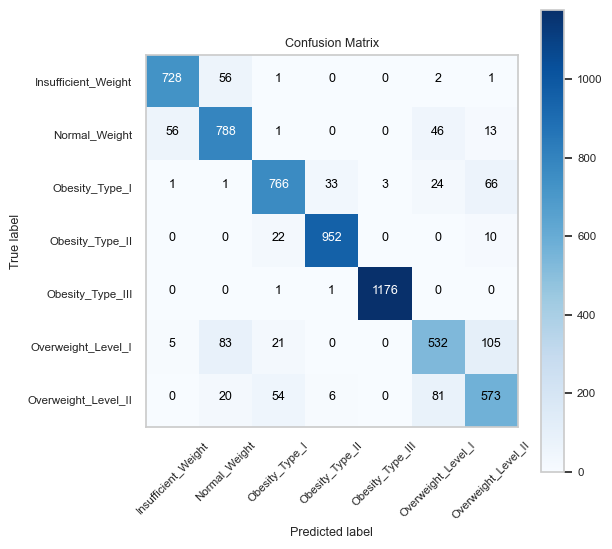

In [29]:
# compute the confusion matrix
cnf_matrix = confusion_matrix(y_test, predictions, 
                              labels = nobeyesdad.transform(nobeyesdad.classes_))
np.set_printoptions(precision=2)

# plot non-normalized confusion matrix
plt.figure(figsize=(6,6))
plot_confusion_matrix(cnf_matrix, classes = list(nobeyesdad.classes_),
                     normalize=False, title='Confusion Matrix')

# Predicting the output

In [30]:
df_pred = df_test.copy().set_index('id')
df_pred.head()

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS
id,,,,,,,,,,,,,,,,
20758,Male,26.90,1.85,120.64,yes,yes,2.94,3.00,Sometimes,no,2.83,no,0.86,0.00,Sometimes,Public_Transportation
20759,Female,21.00,1.60,66.00,yes,yes,2.00,1.00,Sometimes,no,3.00,no,1.00,0.00,Sometimes,Public_Transportation
20760,Female,26.00,1.64,111.60,yes,yes,3.00,3.00,Sometimes,no,2.62,no,0.00,0.25,Sometimes,Public_Transportation
20761,Male,20.98,1.55,103.67,yes,yes,2.00,2.98,Sometimes,no,2.79,no,0.09,0.00,Sometimes,Public_Transportation
20762,Female,26.00,1.63,104.84,yes,yes,3.00,3.00,Sometimes,no,2.65,no,0.00,0.74,Sometimes,Public_Transportation


In [31]:
# align the columns of df_pred to be the same as X
df_pred = df_pred[[x for x in df_pred.columns if x in X.columns]]

# transform the categorical columns using the label encoders
for col in label_encoders.keys():
    try:
        le = label_encoders[col]
        df_pred[col] = le.transform(df_pred[col])
    except:
        pass
df_pred.dtypes

Gender                              int64
Age                               float64
Height                            float64
Weight                            float64
family_history_with_overweight      int64
FCVC                              float64
CAEC                                int64
CH2O                              float64
FAF                               float64
TUE                               float64
MTRANS                              int64
dtype: object

In [32]:
df_pred.reset_index(inplace=True)
df_pred.head()

,id,Gender,Age,Height,Weight,family_history_with_overweight,FCVC,CAEC,CH2O,FAF,TUE,MTRANS
0,20758,1,26.90,1.85,120.64,1,2.94,2,2.83,0.86,0.00,3
1,20759,0,21.00,1.60,66.00,1,2.00,2,3.00,1.00,0.00,3
2,20760,0,26.00,1.64,111.60,1,3.00,2,2.62,0.00,0.25,3
3,20761,1,20.98,1.55,103.67,1,2.00,2,2.79,0.09,0.00,3
4,20762,0,26.00,1.63,104.84,1,3.00,2,2.65,0.00,0.74,3


In [33]:
df_pred["NObeyesdad"] = nobeyesdad.inverse_transform(xgbc.predict(df_pred[X.columns]))
output = df_pred[['id', 'NObeyesdad']].set_index("id")

In [34]:
# show predicted values as required
output

,NObeyesdad
id,
20758,Obesity_Type_II
20759,Overweight_Level_I
20760,Obesity_Type_III
20761,Obesity_Type_I
20762,Obesity_Type_III
...,...
34593,Overweight_Level_II
34594,Overweight_Level_I
34595,Insufficient_Weight


In [35]:
output.to_csv("submission.csv")